# Neural Ordinary Differential Equations (DiffEqFlux tutorial)
https://docs.sciml.ai/DiffEqFlux/stable/examples/neural_ode/

A neural ODE is an ODE where a neural network defines its derivative function. For example, with the multilayer perceptron neural network Lux.Chain(Lux.Dense(2, 50, tanh), Lux.Dense(50, 2)), we can define a differential equation which is u' = NN(u). This is done simply by the NeuralODE struct. Let's take a look at an example.

In [4]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL
using OptimizationOptimisers, Random, Plots

In [13]:
#include("../src/IRKGaussLegendre.jl")
#using .IRKGaussLegendre  ## bertsio lokala exekutatzeko
using IRKGaussLegendre

Let's get a time series array from a spiral ODE to train against.

In [29]:
rng = Xoshiro(0)
u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2]; length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
#ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps))
ode_data = Array(solve(prob_trueode, IRKGL16(); dt=0.25, saveat = tsteps))

2×30 Matrix{Float32}:
 2.0  1.9465    1.74178  1.23834  0.577114  …  1.40685   1.37023  1.29199
 0.0  0.798831  1.46473  1.80877  1.86467      0.451909  0.72924  0.972587

Now let's define a neural network with a NeuralODE layer. First, we define the layer. Here we're going to use Lux.Chain, which is a suitable neural network structure for NeuralODEs with separate handling of state variables:

In our model, we used the x -> x.^3 assumption in the model. By incorporating structure into our equations, we can reduce the required size and training time for the neural network, but a good guess needs to be known!

In [32]:
dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))
p, st = Lux.setup(rng, dudt2)
#prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)
prob_neuralode = NeuralODE(dudt2, tspan, IRKGL16(); dt=0.25, saveat = tsteps)

NeuralODE(
    model = Chain(
        layer_1 = WrappedFunction(#11),
        layer_2 = Dense(2 => 50, tanh),  # 150 parameters
        layer_3 = Dense(50 => 2),       # 102 parameters
    ),
)         # Total: 252 parameters,
          #        plus 0 states.

From here we build a loss function around it. The NeuralODE has an optional second argument for new parameters, which we will use to change the neural network iteratively in our training loop. We will use the L2 loss of the network's output against the time series data:

In [33]:
function predict_neuralode(p)
    Array(prob_neuralode(u0, p, st)[1])
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss
end

loss_neuralode (generic function with 1 method)

We define a callback function. In this example, we set doplot=false because otherwise it would show every step and overflow the documentation, but for your use case set doplot=true to see a live animation of the training process!

In [34]:
# Do not plot by default for the documentation
# Users should change doplot=true to see the plots callbacks
function callback(state, l; doplot = false)
    println(l)
    # plot current prediction against data
    if doplot
        pred = predict_neuralode(state.u)
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end

pinit = ComponentArray(p)
callback((; u = pinit), loss_neuralode(pinit); doplot = true)

LoadError: MethodError: no method matching (::DiffEqFlux.var"#dudt#17"{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::WrappedFunction{var"#11#12"}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}})(::Vector{Float32}, ::Vector{Float32}, ::ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = ViewAxis(1:0, Shaped1DAxis((0,))), layer_2 = ViewAxis(1:150, Axis(weight = ViewAxis(1:100, ShapedAxis((50, 2))), bias = ViewAxis(101:150, Shaped1DAxis((50,))))), layer_3 = ViewAxis(151:252, Axis(weight = ViewAxis(1:100, ShapedAxis((2, 50))), bias = ViewAxis(101:102, Shaped1DAxis((2,))))))}}}, ::Float64)
The function `dudt` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  (::DiffEqFlux.var"#dudt#17")(::Any, ::Any, ::Any)
[0m[90m   @[39m [32mDiffEqFlux[39m [90m~/.julia/packages/DiffEqFlux/5F67W/src/[39m[90m[4mneural_de.jl:50[24m[39m


We then train the neural network to learn the ODE.

Here we showcase starting the optimization with Adam to more quickly find a minimum, and then honing in on the minimum by using LBFGS. By using the two together, we can fit the neural ODE in 9 seconds! (Note, the timing commented out the plotting). You can easily incorporate the procedure below to set up custom optimization problems. For more information on the usage of Optimization.jl, please consult this documentation.

The x and p variables in the optimization function are different from x and p above. The optimization function runs over the space of parameters of the original problem, so x_optimization == p_original.

221.05272
109.83643
112.67619
100.683685
99.884094
99.51407
97.89269
95.51677
93.68558
92.73543
92.2897
92.015656
91.73389
91.35591
90.82844
90.08845
89.105644
87.960846
86.79199
85.71934
84.82266
84.08684
83.30643
82.15554
80.53281
78.57058
76.24056
73.18488
69.84448
65.91414
62.48742
59.713985
57.043922
54.064056
50.85902
47.88465
45.437218
43.277985
41.109875
38.979836
36.844097
34.323
31.937141
32.56732
28.941584
29.68386
28.250906
29.972473
26.885374
27.597208
25.35381
25.949259
23.11565
21.950478
19.258251
18.709175
16.012413
14.898214
12.437964
11.351496
9.449936
8.666134
7.127733
7.2749677
5.9971538
5.8666697
5.1064286
5.126824
5.062311
4.496742
4.909916
4.4014773
4.1524787
5.094456
4.6625633
4.119768
5.481067
4.063754
4.1650753
3.7582052
4.171528
3.709375
3.7436914
3.4091997
3.5874085
3.2331223
3.3963494
3.0626485
3.1263478
2.8989413
2.8796327
2.7338421
2.7291422
2.641153
2.68918
2.5731924
2.5898492
2.5129764
2.6855986
2.5401728
2.4873192
2.4783807
2.433242
2.4718344
2.3993905

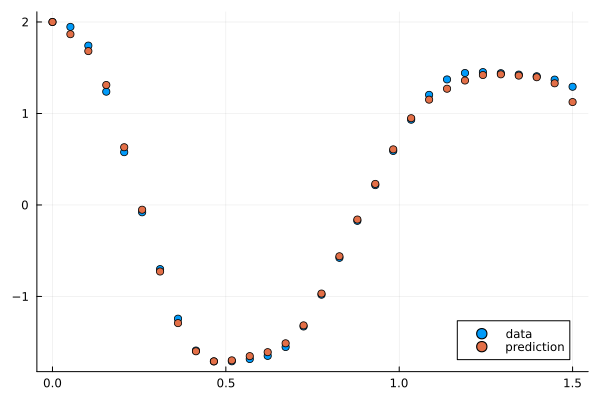

OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[-1.5020273 -2.1919723; 0.679205 0.29877725; … ; 0.96473795 -0.40505263; -0.21477929 -1.9532894], bias = Float32[-0.16590326, 1.3214827, -1.7317672, -0.15964422, 0.097338445, 0.8005946, -0.546663, -1.2214634, -0.18107271, 1.9862046  …  -1.5741652, 0.07433368, -1.1515899, 0.3012553, 0.7263036, 0.30902135, 1.5538136, -0.107876234, 0.035400104, 0.7834836]), layer_3 = (weight = Float32[0.21342103 -0.4363957 … 0.5258814 0.33886626; -0.20410934 -0.059225444 … 0.28120118 -0.46862152], bias = Float32[-0.6136869, -0.33093885]))

In [10]:
# use Optimization.jl to solve the problem
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(0.05); callback = callback, maxiters = 300)

callback((; u = result_neuralode.u), loss_neuralode(result_neuralode.u); doplot = true)

optprob2 = remake(optprob; u0 = result_neuralode.u)

0.3537141


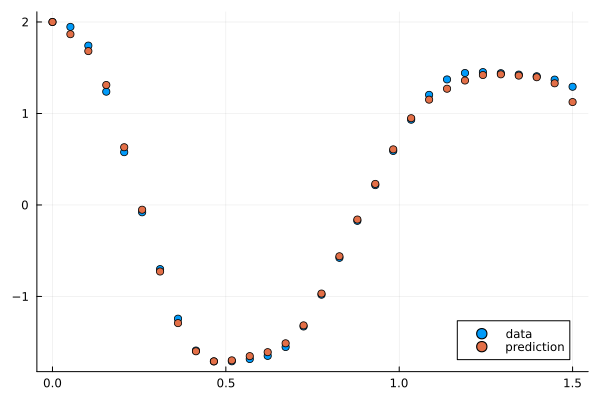

false

In [11]:
callback((; u = result_neuralode.u), loss_neuralode(result_neuralode.u); doplot = true)

We then complete the training using a different optimizer, starting from where Adam stopped. We do allow_f_increases=false to make the optimization automatically halt when near the minimum.

0.3537141
0.35205546
0.34952444
0.28673488
0.21768746
0.1586392
0.1333096
0.11728442
0.113170855
0.102315836
0.09311095
0.0848781
0.07783595
0.067665756
0.05927901
0.05639017
0.054222304
0.045555793
0.04403645
0.040132087
0.033860885
0.031298958
0.028210774
0.026049158
0.0245086
0.024416547
0.024416547
0.023267966
0.02309035
0.022034265
0.019226631
0.018803386
0.017207336
0.016779494
0.015878078
0.015619739
0.015453566
0.014517584
0.014497044
0.014496928
0.014276998
0.013431671
0.01328169
0.01287272
0.012696188
0.011660623
0.011235772
0.010525063
0.010378311
0.010378314
0.010378311


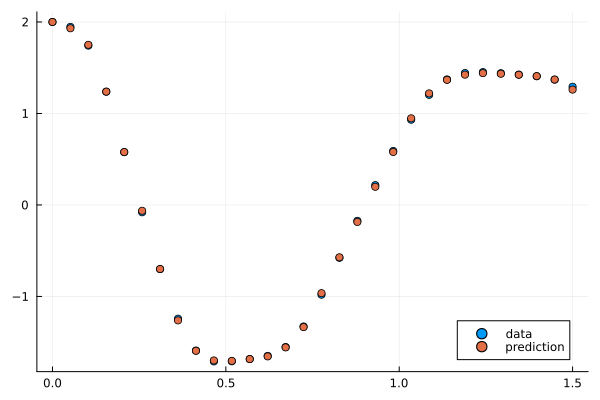

false

In [12]:
result_neuralode2 = Optimization.solve(
    optprob2, Optim.BFGS(; initial_stepnorm = 0.01); callback, allow_f_increases = false)

callback((; u = result_neuralode2.u), loss_neuralode(result_neuralode2.u); doplot = true)